In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import kaggle as kg
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import sklearn
print(sklearn.__version__)


1.7.0


In [3]:
os.environ["USERNAME"] = "ananyachattarjee"
os.environ["KEY"] = "340cf7e2927700b82491dcdaa82ad906"

DATA LOADING

In [4]:
kg.api.authenticate()

In [5]:
# !kaggle competitions download -c house-prices-advanced-regression-techniques -p dataset


In [6]:
# !unzip -q dataset/house-prices-advanced-regression-techniques.zip -d dataset


In [7]:
data = pd.read_csv("dataset/train.csv")

In [8]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


DATA CLEANING

In [9]:
data.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [10]:
data.drop(labels="Id", axis=1, inplace=True)


In [11]:
len(data.columns)

80

In [12]:
print(data.isna().sum()[data.isna().sum() != 0])


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [13]:
missing_percent = data.isna().sum() / len(data) * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


In [14]:

cols_to_drop = missing_percent[missing_percent > 40].index
data.drop(columns=cols_to_drop, inplace=True)

In [15]:
cols_to_drop

Index(['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [16]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [17]:
ordinal_features = [
    "MSSubClass",       # Dwelling type coded with a natural progression
    "OverallQual",      # Overall material and finish quality (1–10)
    "OverallCond",      # Overall condition rating (1–10)
    "LotShape",         # IR3 < IR2 < IR1 < Reg
    "LandSlope",        # Sev < Mod < Gtl
    "ExterQual",        # Po < Fa < TA < Gd < Ex
    "ExterCond",        # Po < Fa < TA < Gd < Ex
    "BsmtQual",         # Po < Fa < TA < Gd < Ex
    "BsmtCond",         # Po < Fa < TA < Gd < Ex
    "BsmtExposure",     # No < Mn < Av < Gd
    "BsmtFinType1",     # Unf < LwQ < Rec < BLQ < ALQ < GLQ
    "BsmtFinType2",     # Same as above
    "HeatingQC",        # Po < Fa < TA < Gd < Ex
    "KitchenQual",      # Po < Fa < TA < Gd < Ex
    "Functional",       # Sev < Maj2 < Maj1 < Mod < Min2 < Min1 < Typ
    "GarageFinish",     # Unf < RFn < Fin
    "GarageQual",       # Po < Fa < TA < Gd < Ex
    "GarageCond",       # Po < Fa < TA < Gd < Ex
    "PavedDrive",       # N < P < Y
]


In [18]:
nominal_features = [
    "MSZoning",         # A, C (all), FV, I, RH, RL, RP, RM
    "Street",           # Gravel, Paved
    "LotConfig",        # Inside, Corner, CulDSac, FR2, FR3
    "Neighborhood",     # Names of neighborhoods in Ames
    "Condition1",       # Artery, Feedr, Norm, RRNe, etc.
    "Condition2",       # Same as above (2nd condition)
    "BldgType",         # 1Fam, 2FmCon, Duplx, Twnhs, TwnhsE
    "HouseStyle",       # 1Story, 2Story, 1.5Fin, SLvl, etc.
    "RoofStyle",        # Flat, Gable, Gambrel, Hip, etc.
    "RoofMatl",         # CompShg, Tar&Grv, etc.
    "Exterior1st",      # VinylSd, MetalSd, etc.
    "Exterior2nd",      # Same as above
    "Foundation",       # PConc, CBlock, BrkTil, etc.
    "Heating",          # GasA, GasW, Grav, etc.
    "CentralAir",       # N, Y
    "Electrical",       # SBrkr, FuseA, FuseF, etc.
    "GarageType",       # Attchd, Detchd, BuiltIn, etc.
    "SaleType",         # WD, New, COD, ConLD, etc.
    "SaleCondition",     # Normal, Abnorml, Partial, etc.
    'LandContour',
    'Utilities'
]


In [19]:
ordinal_mappings = {
        'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3},
        'LandSlope': {'Sev': 0, 'Mod': 1, 'Gtl': 2},
        'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'BsmtQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'BsmtCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4},
        'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
        'BsmtFinType1': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'BsmtFinType2': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'Functional': {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7},
        'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
        'GarageQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'GarageCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
        'PavedDrive': {'N': 0, 'P': 1,'Y':2}}

In [20]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [21]:
len(categorical_cols)

37

In [22]:
len(data.columns)

74

In [23]:
numerical_cols = data.select_dtypes(include=['number']).columns
print(numerical_cols)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [24]:
len(numerical_cols)

37

In [25]:
for col in numerical_cols:
    data[col].fillna(data[col].mean(), inplace = True)

/tmp/ipykernel_234742/3577252641.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


NOW ONLY CATEGORICAL COLUMNS ARE LEFT WITH NaN VALUES 

In [26]:
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace = True)

/tmp/ipykernel_234742/1892068526.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace = True)


In [27]:
print(data.isna().sum()[data.isna().sum() != 0])

Series([], dtype: int64)


EDA 

In [28]:

for col, mapping in ordinal_mappings.items():
    if col in data.columns:  
        data[col] = data[col].replace(mapping)

/tmp/ipykernel_234742/3340625573.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace(mapping)


In [29]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,3,Lvl,AllPub,Inside,2,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,3,Lvl,AllPub,FR2,2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,2,Lvl,AllPub,Inside,2,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,2,Lvl,AllPub,Corner,2,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,2,Lvl,AllPub,FR2,2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,3,Lvl,AllPub,Inside,2,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,3,Lvl,AllPub,Inside,2,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,3,Lvl,AllPub,Inside,2,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,3,Lvl,AllPub,Inside,2,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [30]:
numeric_and_ordinal_cols = list(set(list(numerical_cols) + list(ordinal_features)))
numeric_ordinal_df = data[numeric_and_ordinal_cols]

data_corr = numeric_ordinal_df.corr()

saleprice_corr = data_corr["SalePrice"].sort_values(ascending=False)

strong_corr = saleprice_corr[(saleprice_corr > 0.5) | (saleprice_corr < -0.5)]

print(strong_corr)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
BsmtQual        0.650138
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
GarageFinish    0.537242
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


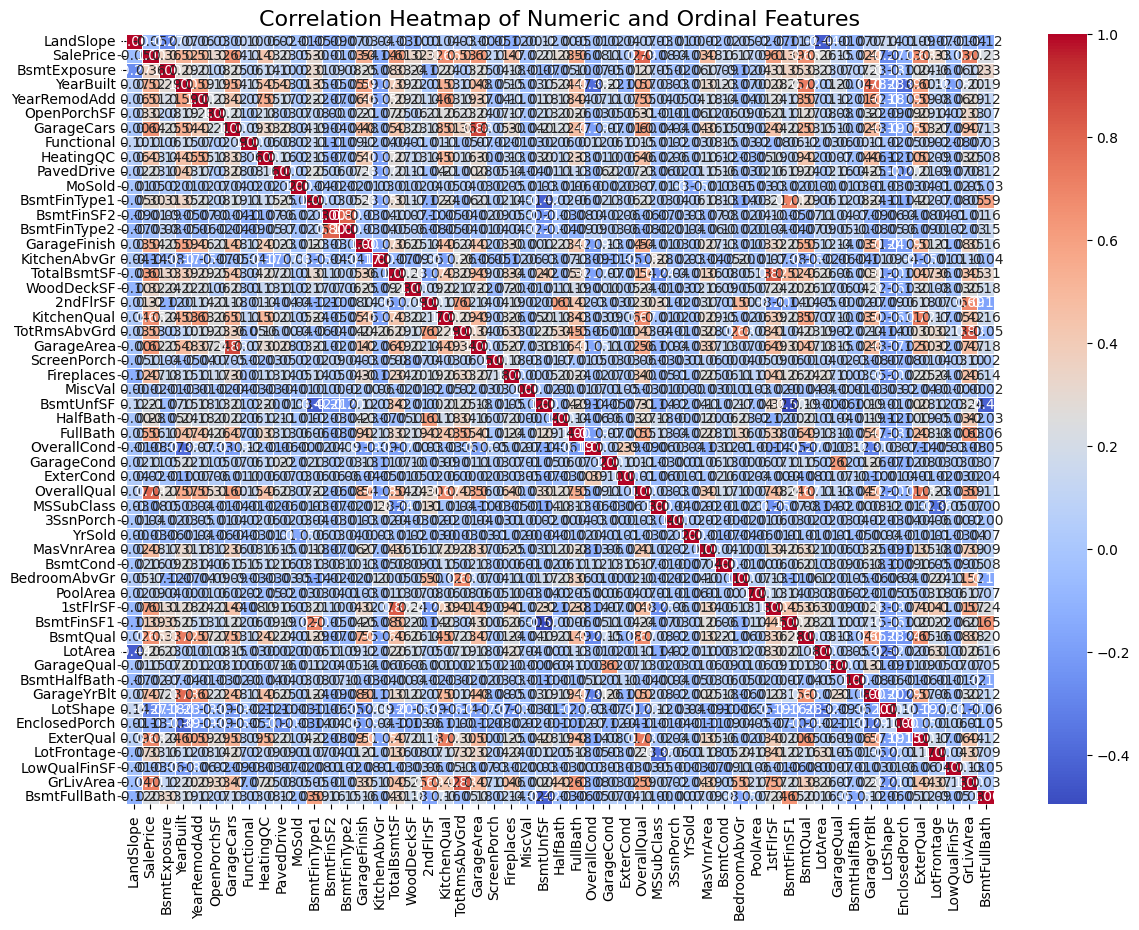

In [31]:
plt.figure(figsize=(14, 10))
sns.heatmap(data_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric and Ordinal Features", fontsize=16)
plt.show()


In [32]:
type(strong_corr)

pandas.core.series.Series

In [33]:
type(nominal_features)

list

In [34]:
nominal_features_cleaned = [col for col in nominal_features if col in data.columns]
combined_cols = strong_corr.index.tolist() + nominal_features_cleaned
useful_col_df = data[combined_cols]


In [35]:
useful_col_df

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,...,Exterior2nd,Foundation,Heating,CentralAir,Electrical,GarageType,SaleType,SaleCondition,LandContour,Utilities
0,208500,7,1710,3,3,4,2,548,856,856,...,VinylSd,PConc,GasA,Y,SBrkr,Attchd,WD,Normal,Lvl,AllPub
1,181500,6,1262,2,2,4,2,460,1262,1262,...,MetalSd,CBlock,GasA,Y,SBrkr,Attchd,WD,Normal,Lvl,AllPub
2,223500,7,1786,3,3,4,2,608,920,920,...,VinylSd,PConc,GasA,Y,SBrkr,Attchd,WD,Normal,Lvl,AllPub
3,140000,7,1717,2,3,3,3,642,756,961,...,Wd Shng,BrkTil,GasA,Y,SBrkr,Detchd,WD,Abnorml,Lvl,AllPub
4,250000,8,2198,3,3,4,3,836,1145,1145,...,VinylSd,PConc,GasA,Y,SBrkr,Attchd,WD,Normal,Lvl,AllPub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,2,4,2,460,953,953,...,VinylSd,PConc,GasA,Y,SBrkr,Attchd,WD,Normal,Lvl,AllPub
1456,210000,6,2073,2,2,4,2,500,1542,2073,...,Plywood,CBlock,GasA,Y,SBrkr,Attchd,WD,Normal,Lvl,AllPub
1457,266500,7,2340,4,3,3,1,252,1152,1188,...,CmentBd,Stone,GasA,Y,SBrkr,Attchd,WD,Normal,Lvl,AllPub
1458,142125,5,1078,2,3,3,1,240,1078,1078,...,MetalSd,CBlock,GasA,Y,FuseA,Attchd,WD,Normal,Lvl,AllPub


In [36]:
data = pd.get_dummies(useful_col_df, columns=nominal_features, drop_first=True,dtype=int)

In [37]:
data

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,...,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa
0,208500,7,1710,3,3,4,2,548,856,856,...,1,0,0,0,1,0,0,0,1,0
1,181500,6,1262,2,2,4,2,460,1262,1262,...,1,0,0,0,1,0,0,0,1,0
2,223500,7,1786,3,3,4,2,608,920,920,...,1,0,0,0,1,0,0,0,1,0
3,140000,7,1717,2,3,3,3,642,756,961,...,1,0,0,0,0,0,0,0,1,0
4,250000,8,2198,3,3,4,3,836,1145,1145,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,2,4,2,460,953,953,...,1,0,0,0,1,0,0,0,1,0
1456,210000,6,2073,2,2,4,2,500,1542,2073,...,1,0,0,0,1,0,0,0,1,0
1457,266500,7,2340,4,3,3,1,252,1152,1188,...,1,0,0,0,1,0,0,0,1,0
1458,142125,5,1078,2,3,3,1,240,1078,1078,...,1,0,0,0,1,0,0,0,1,0


In [38]:
y = data["SalePrice"]

In [39]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [40]:
X= data.drop("SalePrice", axis=1)


In [41]:
X

,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,...,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa
0,7,1710,3,3,4,2,548,856,856,2,...,1,0,0,0,1,0,0,0,1,0
1,6,1262,2,2,4,2,460,1262,1262,2,...,1,0,0,0,1,0,0,0,1,0
2,7,1786,3,3,4,2,608,920,920,2,...,1,0,0,0,1,0,0,0,1,0
3,7,1717,2,3,3,3,642,756,961,1,...,1,0,0,0,0,0,0,0,1,0
4,8,2198,3,3,4,3,836,1145,1145,2,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,2,2,4,2,460,953,953,2,...,1,0,0,0,1,0,0,0,1,0
1456,6,2073,2,2,4,2,500,1542,2073,2,...,1,0,0,0,1,0,0,0,1,0
1457,7,2340,4,3,3,1,252,1152,1188,2,...,1,0,0,0,1,0,0,0,1,0
1458,5,1078,2,3,3,1,240,1078,1078,1,...,1,0,0,0,1,0,0,0,1,0


In [42]:
data

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,...,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa
0,208500,7,1710,3,3,4,2,548,856,856,...,1,0,0,0,1,0,0,0,1,0
1,181500,6,1262,2,2,4,2,460,1262,1262,...,1,0,0,0,1,0,0,0,1,0
2,223500,7,1786,3,3,4,2,608,920,920,...,1,0,0,0,1,0,0,0,1,0
3,140000,7,1717,2,3,3,3,642,756,961,...,1,0,0,0,0,0,0,0,1,0
4,250000,8,2198,3,3,4,3,836,1145,1145,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,2,4,2,460,953,953,...,1,0,0,0,1,0,0,0,1,0
1456,210000,6,2073,2,2,4,2,500,1542,2073,...,1,0,0,0,1,0,0,0,1,0
1457,266500,7,2340,4,3,3,1,252,1152,1188,...,1,0,0,0,1,0,0,0,1,0
1458,142125,5,1078,2,3,3,1,240,1078,1078,...,1,0,0,0,1,0,0,0,1,0


NORMALIZING DATA

In [43]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)


In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)


In [45]:
data

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,...,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa
0,208500,7,1710,3,3,4,2,548,856,856,...,1,0,0,0,1,0,0,0,1,0
1,181500,6,1262,2,2,4,2,460,1262,1262,...,1,0,0,0,1,0,0,0,1,0
2,223500,7,1786,3,3,4,2,608,920,920,...,1,0,0,0,1,0,0,0,1,0
3,140000,7,1717,2,3,3,3,642,756,961,...,1,0,0,0,0,0,0,0,1,0
4,250000,8,2198,3,3,4,3,836,1145,1145,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,2,4,2,460,953,953,...,1,0,0,0,1,0,0,0,1,0
1456,210000,6,2073,2,2,4,2,500,1542,2073,...,1,0,0,0,1,0,0,0,1,0
1457,266500,7,2340,4,3,3,1,252,1152,1188,...,1,0,0,0,1,0,0,0,1,0
1458,142125,5,1078,2,3,3,1,240,1078,1078,...,1,0,0,0,1,0,0,0,1,0


REMOVING OUTLIERS

In [46]:
from scipy.stats import zscore

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

z_scores = zscore(data[numeric_cols])
abs_z_scores = np.abs(z_scores)

filtered_entries = (abs_z_scores < 3).all(axis=1)
data_no_outliers = data[filtered_entries].copy()


In [47]:
data

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,...,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa
0,208500,7,1710,3,3,4,2,548,856,856,...,1,0,0,0,1,0,0,0,1,0
1,181500,6,1262,2,2,4,2,460,1262,1262,...,1,0,0,0,1,0,0,0,1,0
2,223500,7,1786,3,3,4,2,608,920,920,...,1,0,0,0,1,0,0,0,1,0
3,140000,7,1717,2,3,3,3,642,756,961,...,1,0,0,0,0,0,0,0,1,0
4,250000,8,2198,3,3,4,3,836,1145,1145,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,2,4,2,460,953,953,...,1,0,0,0,1,0,0,0,1,0
1456,210000,6,2073,2,2,4,2,500,1542,2073,...,1,0,0,0,1,0,0,0,1,0
1457,266500,7,2340,4,3,3,1,252,1152,1188,...,1,0,0,0,1,0,0,0,1,0
1458,142125,5,1078,2,3,3,1,240,1078,1078,...,1,0,0,0,1,0,0,0,1,0


CREATING NEW COLUMNS THAT CAN TELL BETTER RELATIONSHIP BETWEEN X AND Y [FEATURE ENGINEERING]

In [48]:
data.columns[9:20]

Index(['1stFlrSF', 'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Pave'],
      dtype='object')

In [49]:
print([col for col in data.columns if "Bath" in col])


['FullBath']


In [50]:
data["TotalBathrooms"] = data["FullBath"]


In [51]:
data.drop("FullBath", axis=1, inplace=True)


In [52]:
print([col for col in data.columns if "Year" in col])

['YearBuilt', 'YearRemodAdd']


In [53]:
data['HouseAge'] = 2025 - data['YearBuilt']


In [54]:
data['YearsSinceRemodel'] = 2025 - data['YearRemodAdd']


In [55]:
data['WasRemodeled'] = (data['YearBuilt'] != data['YearRemodAdd']).astype(int)


In [56]:
data.drop(['YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)


In [57]:
X=data

In [58]:
X

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,...,SaleCondition_Normal,SaleCondition_Partial,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,TotalBathrooms,HouseAge,YearsSinceRemodel,WasRemodeled
0,208500,7,1710,3,3,4,2,548,856,856,...,1,0,0,0,1,0,2,22,22,0
1,181500,6,1262,2,2,4,2,460,1262,1262,...,1,0,0,0,1,0,2,49,49,0
2,223500,7,1786,3,3,4,2,608,920,920,...,1,0,0,0,1,0,2,24,23,1
3,140000,7,1717,2,3,3,3,642,756,961,...,0,0,0,0,1,0,1,110,55,1
4,250000,8,2198,3,3,4,3,836,1145,1145,...,1,0,0,0,1,0,2,25,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,2,4,2,460,953,953,...,1,0,0,0,1,0,2,26,25,1
1456,210000,6,2073,2,2,4,2,500,1542,2073,...,1,0,0,0,1,0,2,47,37,1
1457,266500,7,2340,4,3,3,1,252,1152,1188,...,1,0,0,0,1,0,2,84,19,1
1458,142125,5,1078,2,3,3,1,240,1078,1078,...,1,0,0,0,1,0,1,75,29,1


In [59]:
X = X[['GrLivArea', 'OverallQual', 'ExterQual', 'KitchenQual']]


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [62]:
X_train

,GrLivArea,OverallQual,ExterQual,KitchenQual
314,1641,7,2,4
442,1573,5,2,2
319,1472,7,2,2
767,1750,6,2,2
756,1768,8,3,3
...,...,...,...,...
1095,1314,6,3,3
1130,1981,4,2,3
1294,864,5,2,2
860,1426,7,3,3


In [63]:
y_train

314     178000
442     162900
319     187500
767     160000
756     212000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 876, dtype: int64

In [64]:
X_test

,GrLivArea,OverallQual,ExterQual,KitchenQual
892,1068,6,2,2
1105,2622,8,3,3
413,1028,5,2,2
522,1664,6,2,2
1036,1620,9,3,4
...,...,...,...,...
1330,1588,8,3,3
1103,1194,6,2,2
752,1494,6,2,3
1353,3238,8,3,3


In [65]:
y_test

892     154500
1105    325000
413     115000
522     159000
1036    315500
         ...  
1330    227000
1103    159500
752     217000
1353    410000
376     148000
Name: SalePrice, Length: 584, dtype: int64

In [66]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [67]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.7698956072923528
RMSE: 40837.58678236052


In [72]:
import joblib

# Save your trained model
joblib.dump(model, "house_price_model.pkl")


['house_price_model.pkl']

In [73]:
joblib.dump(X_train.columns.tolist(), "model_columns.pkl")


['model_columns.pkl']

In [74]:
feature_means = X_train.mean().to_dict()
joblib.dump(feature_means, "model_defaults.pkl")


['model_defaults.pkl']

🔗 Correlation of features with Price:

SalePrice            1.000000
OverallQual          0.790982
GrLivArea            0.708624
ExterQual            0.682639
KitchenQual          0.659600
                       ...   
MSZoning_RM         -0.288065
Foundation_CBlock   -0.343263
GarageType_Detchd   -0.354141
YearsSinceRemodel   -0.507101
HouseAge            -0.522897
Name: SalePrice, Length: 153, dtype: float64


/tmp/ipykernel_234742/1181296112.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='crest')


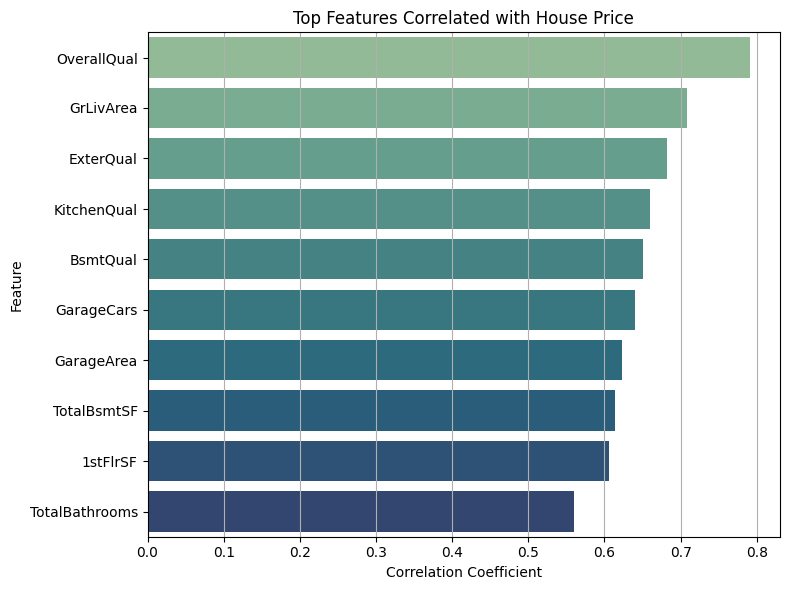

In [75]:
correlation_matrix = data.corr(numeric_only=True)

# Show correlation of features with target 'price'
target_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)

print("🔗 Correlation of features with Price:\n")
print(target_corr)

# Optional: Plot top 10 features most correlated with price (excluding 'price' itself)
top_corr = target_corr.drop('SalePrice').head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='crest')
plt.title("Top Features Correlated with House Price")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()